[Preliminary data formatting](https://colab.research.google.com/drive/1MMwTOOgMKuZMWnsl9vxWUB6reXAZJndc?usp=sharing) was done before loading the data to this notebook.

# Import

We start by importing the necessary libraries (and their dependent requirements) that we will need further down the pipeline to process everything.

In [ ]:
! pip install pymorphy2==0.8 git+https://github.com/buriy/spacy-ru@v2.1 #spacy==2.1.9

In [ ]:
! git clone --branch v2.1 https://github.com/buriy/spacy-ru

Cloning into 'spacy-ru'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 511 (delta 45), reused 83 (delta 25), pack-reused 393
Receiving objects: 100% (511/511), 180.76 MiB | 12.64 MiB/s, done.
Resolving deltas: 100% (215/215), done.


In [ ]:
# nltk will be used for tokenization and stopwords removal
import pandas as pd # for dataframes
import re # for operations with regex
# import numpy as np # for numeric operations
# import os #for misc system-related funcs
from pathlib import Path # for operations with path
from itertools import chain
from joblib import Parallel, delayed

#spacy + pymorphy2 for Russian lemmatization
import spacy 
import pymorphy2

# gensim phrases for ngrams extraction
from gensim.models.phrases import Phrases

## Load data
We now have to get the actual text documents into a dataframe that our notebook will be able to work with. You can think of a dataframe as a table in which 
*   each ***row*** represents one text document, and in which  
*   each ***column*** contains a field such as the full text of the document itself, but also a set of metadata like the document's date of publication, its author, its source, etc. 

These documents have been packaged into a json file.

In [ ]:
data = pd.read_json('/Corpora/Deterrence/200708_ru_deter_full.json', 
                    convert_dates = False)

data.drop(columns=['date'], inplace = True)

data.rename(columns={'date_rough':'date'}, inplace = True)

data["date"] = pd.to_datetime(data["date"], format='%Y-%m-%d %H:%M:%S', errors = 'coerce')

# Corpus stats

In [ ]:
# let's take a look at the time span
print(f'{sum(data["date"].isna())} objects have no date assigned')
print(f'Earliest date in the corpus: {data["date"].min()}')
print(f'Latest date in the corpus: {data["date"].max()}')

1 objects have no date assigned
Earliest date in the corpus: 1961-01-01 00:00:00+00:00
Latest date in the corpus: 2020-01-01 00:00:00+00:00


In [ ]:
#let's now calculate min, avg, max of len and stdv
# first we create a function to generate lengths of each text
import statistics
text_lengths = []
for i in data['fulltext']:
  text_lengths.append(len(i))

In [ ]:
#now let's see how big our texts are
print(f'max text length: {max(text_lengths)}')
print(f'min text length: {min(text_lengths)}')
print(f'mean: {round(statistics.mean(text_lengths))} and median:{statistics.median(text_lengths)}')
print(f'standard deviation of text length: {round(statistics.stdev(text_lengths))}')

max text length: 2341051
min text length: 103
mean: 29116 and median:15407.0
standard deviation of text length: 78162


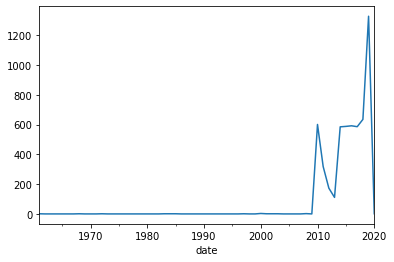

In [ ]:
#let's find out docs distribution over time
import matplotlib.pyplot as plt

docs_time = data.groupby(pd.Grouper(key='date', freq='Y')).fulltext.agg('count')
docs_time.plot.line(y = 'count')

# Preprocessing
Now that we have everything loaded, we can start processing the documents.


## Context window extraction #1

Many of our documents are quite sizeable, and may contain many paragraphs that are not at all relevant to the issue we our interested in (deterrence). This section extracts 'context windows' for excerpts that are relevant for deterrence. You'll find the more detailed documentation [here](https://rizzoma.com/topic/4ccb0b922026dc65818727aaecf5553c/0_b_ajoa_agl7a/)

In [ ]:
pattern = r'устраш|сдерж|запуг' #define patterns it will filter by
negative_pattern = r'сдержанн' #this word is a sure indicator a text is irrelevant

print(f'Before extracting paragraphs: {len(data.index)}')

data = data[data['fulltext'].str.contains(pattern, case = False, regex = True)]

data = data[~data['fulltext'].str.contains(negative_pattern, case = False, regex = True)]

print(f'After extracting relevant paragraphs: {len(data.index)}')
# print an example paragraph

Before extracting paragraphs: 5534
After extracting relevant paragraphs: 4118


In [ ]:
#let's drop NAs and empty strings (given there are any)
print(f'Before dropping NAs: {len(data.index)}')

data.dropna(subset = ['fulltext'], inplace = True)

data = data[data['fulltext']!='']

data = data[data['fulltext'].str.len()>10]

data.reset_index(inplace = True, drop = True)

print(f'After dropping NAs: {len(data.index)}')

Before dropping NAs: 4118
After dropping NAs: 4118


## Tokenization into paragraphs
When humans write texts, they break it up in smaller chunks like sentences of paragraphs. In this pre-processing step, we first split the documents into 'paragraphs' first. Paragraphs in this case are defined as either periods or exclamation/question marks followed by a newline character. 

This approach, while arguably quite brutish, works pretty well.


In [ ]:
paragraph_delim = re.compile(r'!\s*\n|\.+\s*\n|\?\s*\n') # define a pattern for paragraph delimiter

# apply tokenization into paragraphs;
# after applying, each text cell should be a list with paragraph per element
data['fulltext'] = data['fulltext'].apply(lambda a: re.split(paragraph_delim, a)) 

data = data.explode('fulltext') # now let's create a new row from each list element

data.reset_index(inplace = True, drop = True) # and reset index of rows

## Tokenization into sentences and words

In [ ]:
# initialize nlp object
nlp = spacy.load('/content/spacy-ru/ru2', disable = ['parser', 'ner'])
nlp.add_pipe(nlp.create_pipe('sentencizer'), first=True)
nlp.max_length = 300000

Check out [this post](https://towardsdatascience.com/turbo-charge-your-spacy-nlp-pipeline-551435b664ad) for the source of the most code below. Also tried out different approaches to boosting spaCy [here](https://colab.research.google.com/drive/17H2RJsbqbqpw1HR-DhctHIuv3vNplR12?usp=sharing), this one was far the most successful.

In [ ]:
def chunker(iterable, total_length, chunksize):
    #"returns a generator that only contains that particular chunk's text as a list of strings"
    return (iterable[pos: pos + chunksize] for pos in range(0, total_length, chunksize))

def process_chunk(texts, pattern = re.compile(r'[a-z|а-я]+')):
    #processes the texts with an nlp object
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=20):
        processed_doc = [[token.lemma_ for token in sentence if re.match(pattern, token.lemma_)] for sentence in doc.sents]
        preproc_pipe.append(processed_doc)
    return preproc_pipe

def flatten(list_of_lists):
    #"flatten a list of lists to a combined list"
    return [item for sublist in list_of_lists for item in sublist]

def preprocess_parallel(texts, chunksize=100):
    #apply all of the above to process texts in parallel
    executor = Parallel(n_jobs=2, backend='multiprocessing', prefer="processes")
    do = delayed(process_chunk)
    tasks = (do(chunk) for chunk in chunker(texts, len(data), chunksize=chunksize))
    result = executor(tasks)
    return flatten(result)

In [ ]:
%%time

data['processed_text'] = preprocess_parallel(data['fulltext'], chunksize = 100)
# df_preproc[['date', 'content', 'preproc_pipe']].head(3)

CPU times: user 13.1 s, sys: 3.18 s, total: 16.3 s
Wall time: 11min 34s


## N-grams

Gensim Ngrams require the training data to be tokenized into sentences. We'll create a separate variable with sentencized texts for ngrams.

In [ ]:
data['processed_text'].isna().sum()

0

In [ ]:
sentences = data['processed_text'].explode().dropna().tolist()

Here we'll define the normalization func (tokenization and lemmatization) that we'll use later

In [ ]:
%%time
bigram = Phrases(sentences[0:876240], min_count=6, 
                 threshold=25, #we'd still need to experiment with these two params
                 delimiter=b'_')
trigram = Phrases(bigram[sentences], min_count=6, threshold=15, 
                  delimiter=b'_') # add one word to already generated bigrams where possible

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


CPU times: user 1min 57s, sys: 1.16 s, total: 1min 58s
Wall time: 1min 58s


In [ ]:
#let's see an instance of these
print(trigram[bigram[sentences]][4])

sentences = ''

['джон_кеннеди', 'и', 'никита_хрущев', 'в', 'отличие_от', 'фидель_кастро', 'действительно', 'не', 'намного', 'пережить', 'событие', 'карибский_кризис']


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


Now we will apply ngrams



In [ ]:
%%time
data.columns

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 9.78 µs


Index(['author', 'database', 'doi', 'filename', 'fulltext', 'place',
       'pubtitle', 'title', 'url', 'date', 'source_site', 'Pubtype',
       'Author name', 'Title', 'Publication type (civ/mil)',
       'Author background (civ/mil)', 'Gender', 'processed_text'],
      dtype='object')

In [ ]:
# now to underscore all phrases in the texts data['preprocessed_texts']
data['processed_text'] = data['processed_text'].apply(lambda paragraph: [trigram[bigram[sentence]] for sentence in paragraph]) 

/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [ ]:
# let's flatten our paragraphs: we don't need sentence boundaries anymore
# data['processed_text'] = data['processed_text'].apply(lambda l: list(chain(*l)))
print(data['processed_text'][0])

['карибский_кризис', 'два', 'проиграть', 'и', 'один', 'победитель', 'максим', 'кузахметов', 'парадоксальный_образ', 'главный', 'победитель', 'по', 'итог', 'карибский_кризис', 'стать', 'человек', 'чей', 'действие', 'во_многом', 'и', 'спровоцировали', 'драматический', 'противостояние', 'ссср', 'и', 'сша', 'в', 'октябрь_год']


## Remove stopwords
A tricky part here is leaving only meaningful ngrams, which are all *but*:

*   bigrams with one or two stopwords, e.g. "тот_кто" or "с_министром";
*   trigrams with either 3 stopwords or stopwords in the ending/beginning: "когда_президент_с".

Below will be the main function which will check if an ngram passess these requirements. If not - it will either reduce it or completely disintegrate. The function is super clumsy but I couldn't come up with anything better so far.



In [ ]:
# download NLTK stopwords
! wget https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/stopwords.zip && unzip stopwords.zip

--2020-07-14 11:41:28--  https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/stopwords.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23047 (23K) [application/zip]
Saving to: ‘stopwords.zip’

stopwords.zip       100%[===================>]  22.51K  --.-KB/s    in 0.01s   

2020-07-14 11:41:28 (2.24 MB/s) - ‘stopwords.zip’ saved [23047/23047]

Archive:  stopwords.zip
   creating: stopwords/
  inflating: stopwords/dutch         
  inflating: stopwords/german        
  inflating: stopwords/slovene       
  inflating: stopwords/hungarian     
  inflating: stopwords/romanian      
  inflating: stopwords/kazakh        
  inflating: stopwords/turkish       
  inflating: stopwords/russian       
  inflating: stopwords/README        
  inflating

In [ ]:
# load and extend the list of stopwords
with open('/content/stopwords/russian', 'r') as infile:
  stopwords = infile.read().splitlines()

stopwords.extend(['the', 'url', 'com', 'www', 'html', 'and', 'of', 'for', 'news', 'http', 'org', 'метр', 
                        'foreign', 'financial', 'in', 'iss', 'irs', 'n', 'ст', 'index', 'php', 'rp', 'page', 'http', 'этот', 
                        'один', 'x', 'чем', "также", "это", "который", "являться", "весь", "весь", "год", "весь", "год", 
                        "являться", "ещё", "еще", 'net', 'ru', 'a', 'b', 'e', 'ad', 'f'])
print(stopwords)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

Now we can build a function to clean the text from stopwords.

In [ ]:
def clean_ngram(text, stopwords = stopwords):
  new_text = []
  for token in text:
    if type(token) is str:
      if '_' in token:
        ngram = token.split('_')
        if len(ngram) >= 3:
          ngram = [word for ind, word in enumerate(ngram) if word not in stopwords or ind == 1]
        elif len(ngram) == 2:
          ngram = [word for word in ngram if word not in stopwords]
        elif len(ngram) == 0:
          ngram = None      
        
        if len(ngram) == 1:
          ngram = ngram[0]
        elif len(ngram) > 1:
          ngram = ' '.join(ngram)
      
      elif token == '' or token in stopwords:
        ngram = None
      else:
        ngram = token
    else:
      ngram = None
    new_text.append(ngram)
  
  new_text = [token for token in new_text if token] 
  return new_text 

In [ ]:
data['processed_text'] = data['processed_text'].apply(clean_ngram)
data['processed_text'][10]

['время',
 'кризис',
 'день',
 'самой',
 'острый фаза',
 'кризис',
 'хрущев',
 'дать',
 'разрешение',
 'применение ядерный оружие',
 'против',
 'сша',
 'союзник',
 'проявить',
 'инициатива',
 'поиск',
 'мирный путь',
 'выход',
 'опасный',
 'военный',
 'противостояние',
 'решение',
 'вывод',
 'советский',
 'ракета',
 'куба',
 'принимать',
 'фактически',
 'единолично']

## Context window extraction #2 (for ngram analysis)
Now that our corpus is lemmatized and has no stopwords, we can filter out more irrelevant paragraphs and generate the best-quality ngrams for our analysis. For this, we'll try to identify the most common meaningful terms in our golden corpus, and then filter our common corpus on them.

In [ ]:
#https://programminghistorian.org/en/lessons/keywords-in-context-using-n-grams

def get_kwic(wordlist, n = 4, pattern = re.compile('устраш.*|сдерж.*')):
    # kwic = [wordlist[i:i+n] for i in range(len(wordlist)-(n-1))]
    kwic = []
    index = [ind for ind, word in enumerate(wordlist) if re.match(pattern, word)]
    for i in index:
      keywd = (wordlist[(i-n):(i+n)])
      kwic.append(keywd)
    return kwic

In [ ]:
get_kwic(data['processed_text'][2])

[['принятие решение',
  'стать',
  'шаг',
  'путь',
  'сдерживание',
  'распространение',
  'атомный оружие',
  'последующий']]

In [ ]:
keywords = data['processed_text'].apply(get_kwic).explode().dropna()
pd.DataFrame(keywords.to_list())

,0,1,2,3,4,5,6,7
0,принятие решение,стать,шаг,путь,сдерживание,распространение,атомный оружие,последующий
1,внешний политика,аc,www.proatom.ru,сша,сдерживание,россия,новый,американский
2,кеннан,автор,знаменитый,концепция,сдерживание containment,коммунизм,хороший,американский
3,пытаться,проводить,политика,традиционный,сдерживание,несмотря,огромный,объёму
4,страна,наш,дело,вместе,сдерживание,гонка вооружение,несёт,выгода
...,...,...,...,...,...,...,...,...
7572,ситуация,применительно,стратегический,сила,сдерживание,новый,система,оружие
7573,реализовать,свой,ударный потенциал,достаточный,сдерживание,объём,обладать,поражающий фактор
7574,обслуживание,применение,асимметричный,система,сдерживание,штатный численность,должный,предел
7575,корабль,достаточный,обеспечить,асимметричный,сдерживание,None,None,None


In [ ]:
def get_kwic2(wordlist, n = 2, pattern = re.compile('устраш.*|сдерж.*')):
    # kwic = [wordlist[i:i+n] for i in range(len(wordlist)-(n-1))]
    kwic = []
    index = [ind for ind, word in enumerate(wordlist) if re.match(pattern, word)]
    for i in index:
      keywd = ' '.join(wordlist[(i):(i+n)])
      kwic.append(keywd)
      # kwic = '\n'.join(kwic)
      if len(kwic) >=1:
        return kwic
      else:
        return None

In [ ]:
deterrence_ngrams = data['processed_text'].apply(get_kwic2).explode().dropna()
deterrence_ngrams

2               сдерживание распространение
89                       сдерживание россия
148       сдерживание containment коммунизм
237                    сдерживание несмотря
307            сдерживание гонка вооружение
                        ...                
303012           сдерживать доход гражданин
303095                    сдерживание новый
303097      сдерживание штатный численность
303123                          сдерживание
303134                    сдерживаться того
Name: processed_text, Length: 6485, dtype: object

In [ ]:
ngram_counts = pd.DataFrame(deterrence_ngrams.value_counts().reset_index(name = 'count'))
ngram_counts.to_csv('Projects/ND paper/Textmining/ngram.csv')

In [ ]:
keywords.to_csv('ND paper/Textmining/kwic.csv', index = False)

# Saving the output
Further modeling and analysis will be done in a separate notebook.

In [ ]:
data.columns

Index(['author', 'database', 'doi', 'filename', 'fulltext', 'place',
       'pubtitle', 'title', 'url', 'date', 'source_site', 'Pubtype',
       'Author name', 'Title', 'Publication type (civ/mil)',
       'Author background (civ/mil)', 'Gender', 'processed_text'],
      dtype='object')

In [ ]:
data.drop(columns = ['fulltext', 'filename'], inplace = True)
data.rename(columns = {'processed_text':'fulltext'}, inpalce = True)

In [ ]:
#save the processed corpus
# !mkdir "/content/drive/My Drive/HCSS Projects/Finnish ND paper/Topic modeling"

data.to_json('ND paper/Textmining/200713_deter_evp_preprocessed.json',
                  orient = 'records', force_ascii=False, date_format = 'iso')